In [2]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [4]:
symbol = 'EUR_USD'

In [5]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [13]:
raw

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898
...,...,...,...,...
2019-12-31 22:11:00,1.1212,1.1211,1.1212,1.1211
2019-12-31 23:01:00,1.1212,1.1211,1.1211,1.1211
2019-12-31 23:03:00,1.1212,1.1211,1.1212,1.1211


In [11]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [15]:
data = data.resample('1h', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 03:00:00 to 2020-01-01 02:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


<Axes: xlabel='Date'>

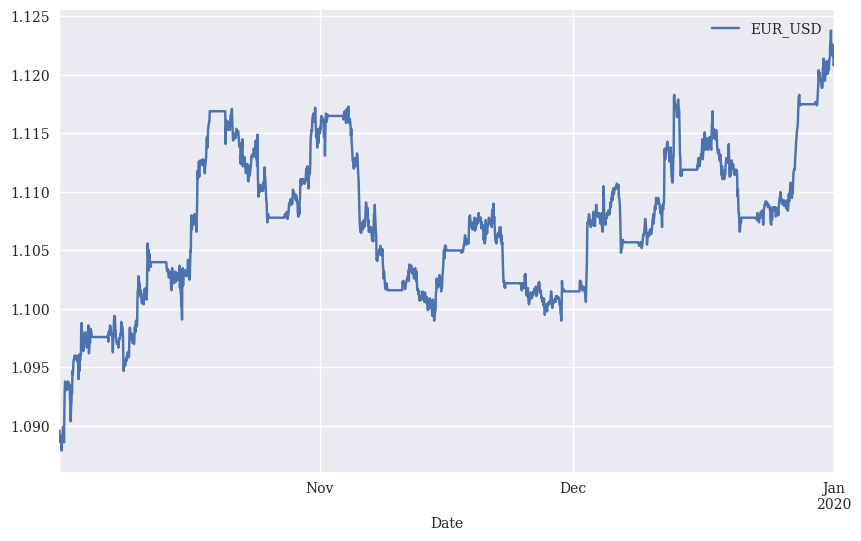

In [16]:
data.plot(figsize=(10, 6))

In [17]:
lags = 5

In [18]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']

    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [19]:
data, cols = add_lags(data, symbol, lags)

In [20]:
len(data)

2183

In [21]:
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [22]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [23]:
class_weight = cw(data)
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [24]:
class_weight[0] * c[0]

1091.5

In [25]:
class_weight[1] * c[1]

1091.5

In [26]:
import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [27]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [29]:
optimizer = Adam(learning_rate=0.001)

In [30]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [31]:
set_seeds()

In [32]:
model = create_model(hl=1, hu=128)

In [33]:
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

In [34]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 411us/step - loss: 0.6016 - accuracy: 0.5754


[0.6016420722007751, 0.5753549933433533]

In [35]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

69/69 [==============================] - 0s 359us/step


In [36]:
data['p'].value_counts()

1    1585
0     598
Name: p, dtype: int64

In [37]:
split = int(len(data) * 0.8)

In [38]:
train = data.iloc[:split].copy()
test = data.iloc[split:].copy()

In [70]:
set_seeds()

In [71]:
model = create_model(hl=1, hu=128)

In [72]:
history = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

In [73]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 389us/step - loss: 0.6293 - accuracy: 0.5830


[0.6293023824691772, 0.5830469727516174]

In [74]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 394us/step


In [75]:
test['p'].value_counts()

1    294
0    143
Name: p, dtype: int64

In [76]:
res = pd.DataFrame(history.history)

<Axes: >

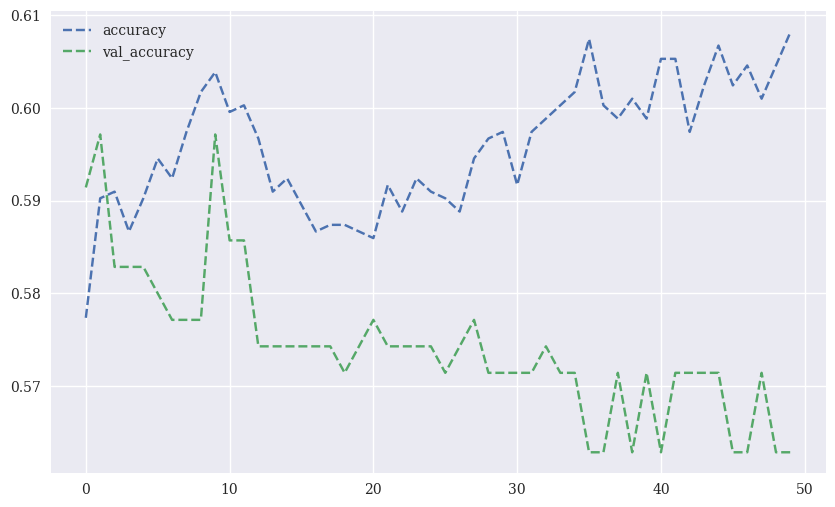

In [77]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [78]:
mu, std = train.mean(), train.std()

In [79]:
train_ = (train - mu) / std

In [80]:
set_seeds()

In [81]:
model = create_model(hl=2, hu=128)

In [82]:
history = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

In [83]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 390us/step - loss: 0.3409 - accuracy: 0.9049


[0.3409072160720825, 0.904925525188446]

In [84]:
test_ = (test - mu) / std

In [85]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 980us/step - loss: 1.1720 - accuracy: 0.6316


[1.1720271110534668, 0.6315789222717285]

In [86]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 442us/step


In [87]:
test['p'].value_counts()

0    253
1    184
Name: p, dtype: int64

In [88]:
res = pd.DataFrame(history.history)

<Axes: >

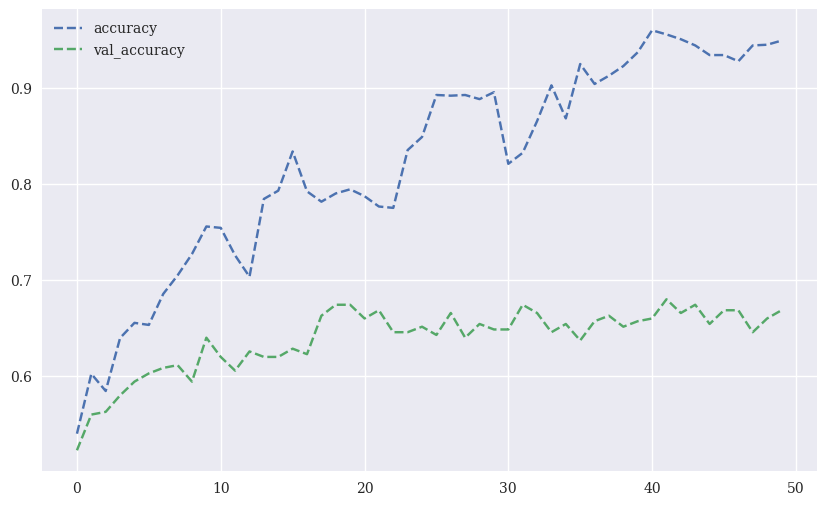

In [89]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [90]:
from keras.layers import Dropout

In [91]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [92]:
set_seeds()

In [93]:
model = create_model(hl=1, hu=128, rate=0.3)

In [94]:
history = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

In [95]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 654us/step - loss: 0.4561 - accuracy: 0.7715


[0.45605409145355225, 0.7714776396751404]

In [96]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 1ms/step - loss: 0.5706 - accuracy: 0.6453


[0.5706065893173218, 0.6453089118003845]

In [97]:
res = pd.DataFrame(history.history)

<Axes: >

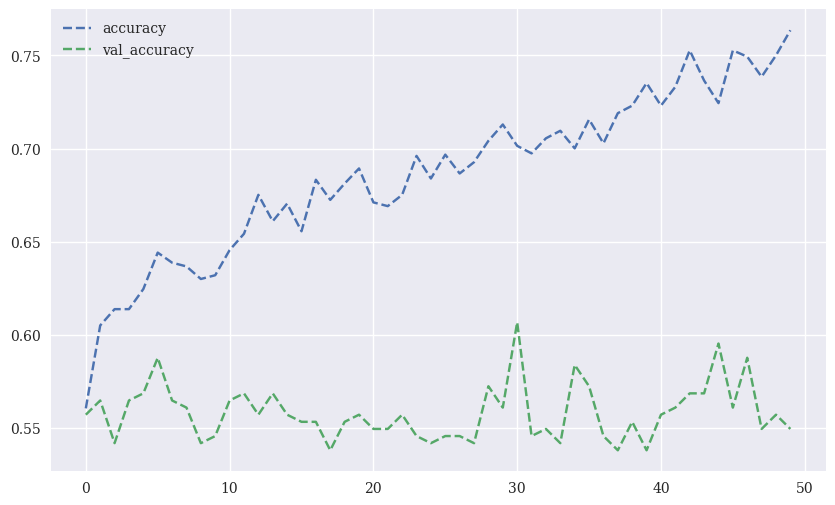

In [98]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [99]:
from keras.regularizers import l1, l2

In [100]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))

        if dropout:
            model.add(Dropout(rate, seed=100))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [101]:
set_seeds()

In [102]:
model = create_model(hl=1, hu=128, regularize=True)

In [103]:
history = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

In [104]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 431us/step - loss: 0.3605 - accuracy: 0.8757


[0.3605187237262726, 0.8757159113883972]

In [105]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 495us/step - loss: 0.8055 - accuracy: 0.6339


[0.8055075407028198, 0.6338672637939453]

In [106]:
res = pd.DataFrame(history.history)

<Axes: >

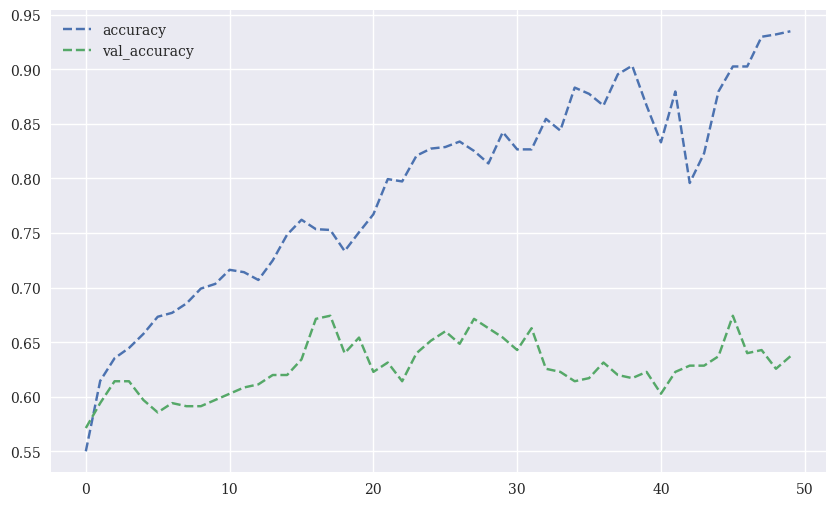

In [107]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [108]:
set_seeds()

In [109]:
model = create_model(hl=2, hu=128, dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001))

In [110]:
history = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

In [111]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 665us/step - loss: 0.4497 - accuracy: 0.7898


[0.4496620297431946, 0.7898052930831909]

In [112]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 528us/step - loss: 0.6060 - accuracy: 0.6247


[0.6060280799865723, 0.6247139573097229]

In [113]:
res = pd.DataFrame(history.history)

<Axes: >

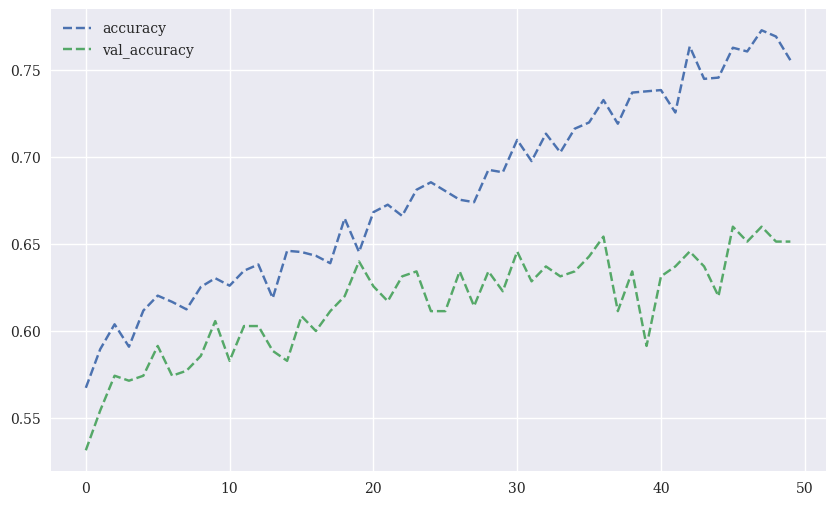

In [114]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [115]:
from sklearn.ensemble import BaggingClassifier
from scikeras.wrappers import KerasClassifier

In [116]:
max_features = 0.75

In [117]:
set_seeds()

In [118]:
base_estimator = KerasClassifier(build_fn=create_model,
                                 verbose=False, epochs=20, hl=1, hu=128,
                                 dropout=True, regularize=False,
                                 input_dim=int(len(cols) * max_features))

In [119]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=15,
                              max_samples=0.75,
                              max_features=max_features,
                              bootstrap=True,
                              bootstrap_features=True,
                              n_jobs=1,
                              random_state=100)

In [120]:
model_bag.fit(train_[cols], train['d'])

/Users/taemin/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/taemin/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/taemin/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/taemin/anaconda3/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/taemin/anaconda3/lib/python3.10/site-

BaggingClassifier(base_estimator=KerasClassifier(build_fn=<function create_model at 0x2a28f0ee0>, dropout=True, epochs=20, hl=1, hu=128, input_dim=30, regularize=False, verbose=False),
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [121]:
model_bag.score(train_[cols], train['d'])

0.709049255441008

In [122]:
model_bag.score(test_[cols], test['d'])

0.6636155606407322

In [123]:
test['p'] = model_bag.predict(test_[cols])

In [124]:
test['p'].value_counts()

0    409
1     28
Name: p, dtype: int64

In [125]:
import time

In [127]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']

In [128]:
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128, dropout=True, rate=0.3,
                         regularize=False, reg=l2(0.001),
                         optimizer=optimizer)
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f} | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 2.1231 | in-sample=0.6346 | out-of-sample=0.6728
rmsprop    | time[s]: 2.1550 | in-sample=0.7772 | out-of-sample=0.6499
adagrad    | time[s]: 2.0181 | in-sample=0.6254 | out-of-sample=0.6613
adadelta   | time[s]: 2.0996 | in-sample=0.3396 | out-of-sample=0.3501
adam       | time[s]: 2.3645 | in-sample=0.7721 | out-of-sample=0.6407
adamax     | time[s]: 2.0581 | in-sample=0.6758 | out-of-sample=0.6293
nadam      | time[s]: 2.3033 | in-sample=0.7784 | out-of-sample=0.6590
